classificar em 2 a 8 hz

In [1]:
import pyedflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import rfft, irfft, fftfreq
import scipy as sp
from scipy import signal

import os
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

In [2]:
HOME = "/home/jonnatas/git/mlModels/sistema/modelo/DB_REPO/edf/"
def dadosPK(tipo):
    dir_ct = HOME+tipo+"/"
    return os.listdir(HOME+tipo+"/")
def carregarDataFrame(tipo, caminho):
    caminho = HOME+tipo+"/"+caminho
    
    edf = pyedflib.EdfReader(caminho)
    n = edf.signals_in_file
    sigbufs = np.zeros((n, edf.getNSamples()[0]))
    for i in np.arange(n):
         sigbufs[i, :] = edf.readSignal(i)
    edf._close()
    del edf
    data = sigbufs.T
    
    return pd.DataFrame(data=data, columns=['ch1', 'ch2', 'ch3', 'ch4'])

In [3]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Matriz de confusão, sem normalização', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Esperado')
    plt.xlabel('Obtido')

In [28]:
def fft(df, canal):
    amostras_validas = df[canal][2000:11000]
    amostras = int(amostras_validas.shape[0]*500/2000)
    sinal = np.abs(np.fft.fft(amostras_validas))[:amostras]
    freq = np.linspace(0,500,amostras)

    return (sinal,freq)

def frequecia(df, canal):
    sinalFFT = [fft(data, canal)[0] for data in df]
    return sinalFFT

In [5]:
nomes_parkinson = dadosPK('parkinson')
nomes_controle = dadosPK('controle')
df_ct = [ carregarDataFrame('controle', nome) for nome in nomes_controle]
df_pk = [ carregarDataFrame('parkinson', nome) for nome in nomes_parkinson]

# Filtrando os dados com a fft

In [34]:
sinalCT = frequecia(df_ct, 'ch1')
sinalPK = frequecia(df_pk, 'ch1')

rotulosCT = [0 for _ in sinalCT]
rotulosPK = [1 for _ in sinalPK]

trainData = sinalCT + sinalPK
rotulos = rotulosCT + rotulosPK

In [41]:
print(len(trainData[0]))
trainData[0]


2250


array([7815.42222222,  726.16013322,  985.22650295, ...,  714.72759129,
        182.35500781,  388.63330226])

In [46]:
print(len(X_train[0]))
X_train[0]

2250


array([5522.85      ,  199.85632219,  323.18107796, ...,  420.63356811,
        862.42914931,  727.50279608])

In [47]:
print(len(X_test[0]))
X_test[0]

2250


array([3163.26976744,   35.21009018, 2499.18175935, ...,  633.30963496,
        518.5572047 ,  254.36506494])

In [51]:
grid.predict([X_test[0]])

array([1])

## Separando os dados (Treino, teste e validação)

In [7]:
# Croos validation
random_state = 32
X_train, X_test, y_train, y_test = train_test_split(trainData, rotulos, test_size=0.3, random_state=random_state)
X_validate, X_test, y_validade, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state) #34,47,77, 9,

# 1. SVM

In [8]:
param_grid = [
    {'C': [1], 'gamma': [0.2], 'kernel':['poly'], 'degree':[3]}
]
grid = GridSearchCV(SVC(random_state=random_state), param_grid, refit=True)

In [9]:
%%time
grid.fit(X_train, y_train)
print(grid.best_params_)

{'C': 1, 'degree': 3, 'gamma': 0.2, 'kernel': 'poly'}
CPU times: user 39.5 ms, sys: 0 ns, total: 39.5 ms
Wall time: 38.7 ms


             precision    recall  f1-score   support

   controle       0.83      0.71      0.77         7
  parkinson       0.71      0.83      0.77         6

avg / total       0.78      0.77      0.77        13



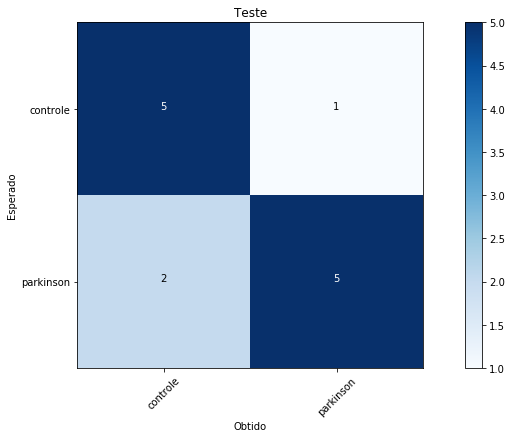

In [10]:
nomes = ['controle','parkinson']
y_pred = grid.predict(X_test)

print(classification_report(y_pred, y_test,target_names=nomes))
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, normalize=False, classes=nomes, title="Teste")

             precision    recall  f1-score   support

   controle       0.88      0.88      0.88         8
  parkinson       0.80      0.80      0.80         5

avg / total       0.85      0.85      0.85        13



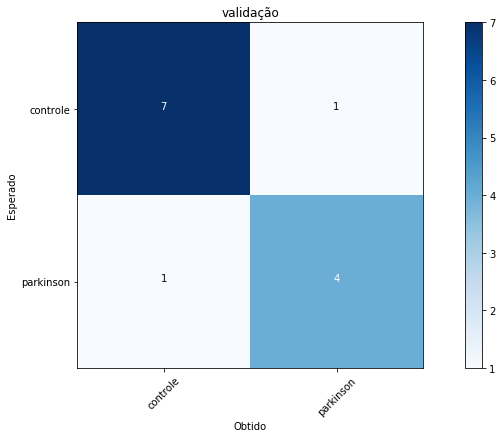

In [11]:
y_predV = grid.predict(X_validate)
print(classification_report(y_predV, y_validade,target_names=nomes))

cnf_matrix = confusion_matrix(y_validade, y_predV)
plot_confusion_matrix(cnf_matrix, normalize=False, classes=nomes, title="validação")

# 2. Randon Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=random_state)

In [13]:
param_grid = [{
    'n_estimators': [200, 100],
    'max_features': ['log2','sqrt'],
    'max_depth' : [5,None]
}]


In [14]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid)

In [15]:
%%time
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}
CPU times: user 3.13 s, sys: 3.54 ms, total: 3.13 s
Wall time: 2.92 s


             precision    recall  f1-score   support

   controle       0.50      0.38      0.43         8
  parkinson       0.29      0.40      0.33         5

avg / total       0.42      0.38      0.39        13



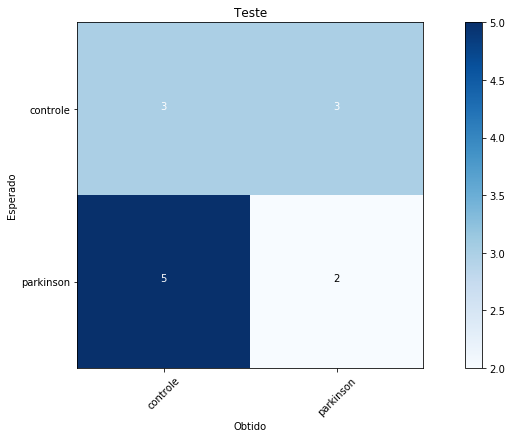

In [16]:
y_pred = CV_rfc.predict(X_test)
print(classification_report(y_pred, y_test,target_names=nomes))
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, normalize=False, classes=nomes, title="Teste")

             precision    recall  f1-score   support

   controle       0.75      1.00      0.86         6
  parkinson       1.00      0.71      0.83         7

avg / total       0.88      0.85      0.84        13



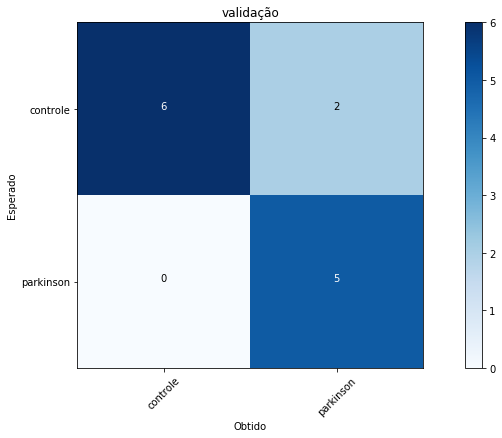

In [17]:
y_predV = CV_rfc.predict(X_validate)
print(classification_report(y_predV, y_validade,target_names=nomes))

cnf_matrix = confusion_matrix(y_validade, y_predV)
plot_confusion_matrix(cnf_matrix, normalize=False, classes=nomes, title="validação")

# 3. Nearest Neighbors

In [18]:
from sklearn import neighbors

In [19]:
param_grid = [
    {'algorithm': ['auto'], 'leaf_size': [30], 'n_neighbors': [3], 'weights': ['uniform']}
]

In [20]:
knn = neighbors.KNeighborsClassifier()

In [21]:
CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid)

In [22]:
%%time
CV_knn.fit(X_train, y_train)
print(CV_knn.best_params_)

{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}
CPU times: user 30.7 ms, sys: 3.99 ms, total: 34.7 ms
Wall time: 33.8 ms


             precision    recall  f1-score   support

   controle       0.83      0.45      0.59        11
  parkinson       0.14      0.50      0.22         2

avg / total       0.73      0.46      0.53        13



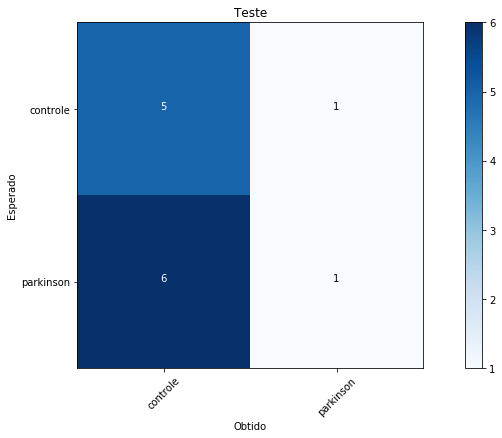

In [23]:
y_pred = CV_knn.predict(X_test)
print(classification_report(y_pred, y_test,target_names=nomes))
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, normalize=False, classes=nomes, title="Teste")

             precision    recall  f1-score   support

   controle       0.75      0.75      0.75         8
  parkinson       0.60      0.60      0.60         5

avg / total       0.69      0.69      0.69        13



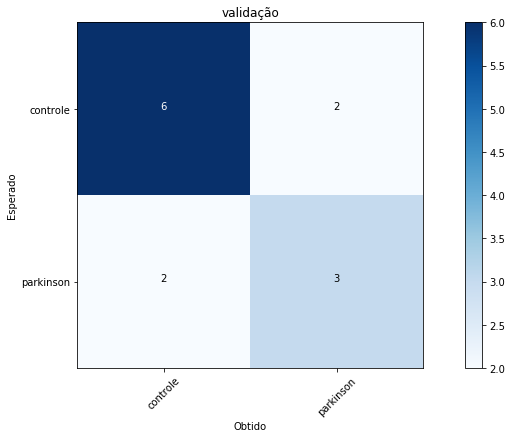

In [24]:
y_predV = CV_knn.predict(X_validate)
print(classification_report(y_predV, y_validade,target_names=nomes))

cnf_matrix = confusion_matrix(y_validade, y_predV)
plot_confusion_matrix(cnf_matrix, normalize=False, classes=nomes, title="validação")

# Range

## Randon Forest

In [25]:
#best = [61,62,71,76,80,94,96,103,140,142,147,165,179,182,]
best = [96,140]
param_grid = [{
    'n_estimators': [100],
    'max_features': ['log2'],
    'max_depth' : [5]
    }]
nomes = ['controle','parkinson']
rfc = RandomForestClassifier(random_state=random_state)
for i in best:
    X_train, X_test, y_train, y_test = train_test_split(trainData, rotulos, test_size=0.3, random_state=i)
    #X_test, X_validate, y_test, y_validade = train_test_split(X_test, y_test, test_size=0.5, random_state=i)
    grid = GridSearchCV(rfc, param_grid, refit=True, verbose=3)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    #y_pred_val = grid.predict(X_validate)
    print(grid.best_params_)
    print(str(i)+"#")
    print("Teste")
    print(classification_report(y_pred, y_test,target_names=nomes))
    print("Validação")
    #print(classification_report(y_pred_val, y_validade,target_names=nomes))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=5, max_features=log2, n_estimators=100 ................
[CV]  max_depth=5, max_features=log2, n_estimators=100, score=0.7, total=   0.1s
[CV] max_depth=5, max_features=log2, n_estimators=100 ................
[CV]  max_depth=5, max_features=log2, n_estimators=100, score=0.7894736842105263, total=   0.1s
[CV] max_depth=5, max_features=log2, n_estimators=100 ................
[CV]  max_depth=5, max_features=log2, n_estimators=100, score=0.8421052631578947, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
96#
Teste
             precision    recall  f1-score   support

   controle       0.79      0.85      0.81        13
  parkinson       0.83      0.77      0.80        13

avg / total       0.81      0.81      0.81        26

Validação
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=5, max_features=log2, n_estimators=100 ................
[CV]  max_depth=5, max_features=log2, n_estimators=100, score=0.6, total=   0.1s
[CV] max_depth=5, max_features=log2, n_estimators=100 ................
[CV]  max_depth=5, max_features=log2, n_estimators=100, score=0.7, total=   0.1s
[CV] max_depth=5, max_features=log2, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


[CV]  max_depth=5, max_features=log2, n_estimators=100, score=0.7222222222222222, total=   0.1s
{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
140#
Teste
             precision    recall  f1-score   support

   controle       0.92      0.92      0.92        13
  parkinson       0.92      0.92      0.92        13

avg / total       0.92      0.92      0.92        26

Validação


## SVM

In [26]:
#best = [7,12,32,46,63,69,71,77,100,123,145,148,]
#besti = [0,12,32,71,77,100,145,148,]
best = [77,148,]
param_grid = [
    {'C': [1], 'gamma': [0.2], 'kernel':['poly'], 'degree':[3,4]}
]

for i in best:
    X_train, X_test, y_train, y_test = train_test_split(trainData, rotulos, test_size=0.3, random_state=i)
   # X_test, X_validate, y_test, y_validade = train_test_split(X_test, y_test, test_size=0.5, random_state=i)
    svc = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    #y_pred_val = svc.predict(X_validate)
    print(svc.best_params_)
    print(str(i)+"#")
    print("Teste")
    print(classification_report(y_pred, y_test,target_names=nomes))
    #print("Validação")
    #print(classification_report(y_pred_val, y_validade,target_names=nomes))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] C=1, degree=3, gamma=0.2, kernel=poly ...........................
[CV]  C=1, degree=3, gamma=0.2, kernel=poly, score=0.65, total=   0.0s
[CV] C=1, degree=3, gamma=0.2, kernel=poly ...........................
[CV]  C=1, degree=3, gamma=0.2, kernel=poly, score=0.7894736842105263, total=   0.0s
[CV] C=1, degree=3, gamma=0.2, kernel=poly ...........................
[CV]  C=1, degree=3, gamma=0.2, kernel=poly, score=0.631578947368421, total=   0.0s
[CV] C=1, degree=4, gamma=0.2, kernel=poly ...........................
[CV]  C=1, degree=4, gamma=0.2, kernel=poly, score=0.65, total=   0.0s
[CV] C=1, degree=4, gamma=0.2, kernel=poly ...........................
[CV]  C=1, degree=4, gamma=0.2, kernel=poly, score=0.7368421052631579, total=   0.0s
[CV] C=1, degree=4, gamma=0.2, kernel=poly ...........................
[CV]  C=1, degree=4, gamma=0.2, kernel=poly, score=0.7368421052631579, total=   0.0s
{'C': 1, 'degree': 4, 'gamma': 0.2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished


## KNN

In [27]:
param_grid = [
    {'algorithm': ['auto'], 'leaf_size': [30], 'n_neighbors': [3], 'weights': ['uniform']}
]
best = [31,117]
for i in best:
    X_train, X_test, y_train, y_test = train_test_split(trainData, rotulos, test_size=0.3, random_state=i)
   # X_test, X_validate, y_test, y_validade = train_test_split(X_test, y_test, test_size=0.5, random_state=i)
    knn = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, refit=True, verbose=3)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    #y_pred_val = svc.predict(X_validate)
    print(knn.best_params_)
    print(str(i)+"#")
    print("Teste")
    print(classification_report(y_pred, y_test,target_names=nomes))
    #print("Validação")
    #print(classification_report(y_pred_val, y_validade,target_names=nomes))


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] algorithm=auto, leaf_size=30, n_neighbors=3, weights=uniform ....
[CV]  algorithm=auto, leaf_size=30, n_neighbors=3, weights=uniform, score=0.8, total=   0.0s
[CV] algorithm=auto, leaf_size=30, n_neighbors=3, weights=uniform ....
[CV]  algorithm=auto, leaf_size=30, n_neighbors=3, weights=uniform, score=0.631578947368421, total=   0.0s
[CV] algorithm=auto, leaf_size=30, n_neighbors=3, weights=uniform ....
[CV]  algorithm=auto, leaf_size=30, n_neighbors=3, weights=uniform, score=0.631578947368421, total=   0.0s
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}
31#
Teste
             precision    recall  f1-score   support

   controle       0.53      0.69      0.60        13
  parkinson       0.56      0.38      0.45        13

avg / total       0.54      0.54      0.53        26

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] algorithm=auto, leaf_size=30, n_neighbors=3, weights=

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
